<a href="https://colab.research.google.com/github/AUBAI-ALKHABBAZ/yolov5_fruits_3_classes/blob/main/ResNet_18_last_apples_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os, time
import numpy as np
import random
random.seed(42)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report

import torch
torch.manual_seed(42)
from torch import nn
from torch.optim import SGD, Adam
from torch.utils.data import DataLoader, RandomSampler
from torch.utils.data.dataset import Dataset
from torchvision.models import resnet
from torchvision import transforms, datasets, models
from torch.optim.lr_scheduler import ReduceLROnPlateau

print('PyTorch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

PyTorch 2.0.1+cu118 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15101MB, multi_processor_count=40)


In [ ]:
def load_transform_images(images_path, presplit, train_split, test_split, val_split, batch_size, threads, mean, std):
    train_transform = transforms.Compose([
                                         #transforms.RandomRotation(degrees=15),
                                         #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                                         #transforms.RandomResizedCrop((224,224)),
                                         transforms.Resize((224,224)),
                                         transforms.RandomHorizontalFlip(),
                                         transforms.ToTensor(),
                                         transforms.Normalize(torch.Tensor(mean),
                                                              torch.Tensor(std))])

    test_transform = transforms.Compose([
                                        transforms.Resize((224,224)),
                                        #transforms.CenterCrop((224,224)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(torch.Tensor(mean),
                                                             torch.Tensor(std))])

    val_transform = transforms.Compose([
                                       transforms.Resize((224,224)),
                                       #transforms.CenterCrop((224,224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize(torch.Tensor(mean),
                                                            torch.Tensor(std))])

    if presplit:
        try:
            training_set = datasets.ImageFolder(root=images_path+'/Training', transform=train_transform)
            validation_set = datasets.ImageFolder(root=images_path+'/Test', transform=val_transform)
        except FileNotFoundError:
            raise Exception('Not presplit into Training and Validation sets')
        try:
            testing_set = datasets.ImageFolder(root=images_path+'/val', transform=test_transform)
        except:
            testing_set = validation_set
        dataset = training_set
    else:
        dataset = datasets.ImageFolder(root=images_path, transform=train_transform)
        train_size = int(train_split * len(dataset))
        test_size = int(test_split * len(dataset))
        val_size = len(dataset) - train_size - test_size
        training_set, testing_set, validation_set = torch.utils.data.random_split(dataset, [train_size, test_size, val_size])

    training_set_loader = DataLoader(training_set, batch_size=batch_size, num_workers=threads, shuffle=True)
    validation_set_loader = DataLoader(validation_set, batch_size=batch_size, num_workers=threads, shuffle=True)
    testing_set_loader = DataLoader(testing_set, batch_size=batch_size, num_workers=threads, shuffle=False)

    return training_set_loader, testing_set_loader, validation_set_loader, dataset, training_set, testing_set, validation_set

def load_network(net_model, net_name, dropout_ratio, class_names):
    for name, param in net_model.named_parameters():
        param.requires_grad = False

    if net_name.startswith('resnet'):
        num_ftrs = net_model.fc.in_features
        net_model.fc = nn.Sequential(nn.Linear(num_ftrs, 256),
                                     nn.ReLU(),
                                     nn.Dropout(p=dropout_ratio),
                                     nn.Linear(256, len(class_names)))
        display(net_model)

    elif net_name.startswith('vgg'):
        num_ftrs = net_model.classifier[6].in_features
        net_model.classifier[6] = nn.Sequential(nn.Linear(num_ftrs, 256),
                                                nn.ReLU(),
                                                nn.Dropout(p=dropout_ratio),
                                                nn.Linear(256, len(class_names)))
        display(net_model.classifier)

    total_params = sum(param.numel() for param in net_model.parameters())
    print(f'{total_params:,} total parameters')

    total_trainable_params = sum(param.numel() for param in net_model.parameters() if param.requires_grad)
    print(f'{total_trainable_params:,} training parameters')

    return net_model

In [ ]:
def plot_images_per_class(images_path, mode, title):
    data_folder = images_path+'/'+mode+'/'
    item_dict = {root.split('/')[-1]: len(files) for root, _, files in os.walk(data_folder)}

    plt.figure(figsize=(20,8))
    plt.bar(list(item_dict.keys())[1:], list(item_dict.values())[1:], color='g')
    plt.title(title)
    plt.xticks(rotation=90)
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.show()

def plot_grid_images(training_set, batch_size, class_names, mean, std, rows=3, columns=3, size=14):
    sampler = RandomSampler(training_set, num_samples=batch_size, replacement=True)
    train_loader = DataLoader(training_set, sampler=sampler, shuffle=False, batch_size=batch_size, num_workers=0)

    dataiter = iter(train_loader)
    #images, labels = dataiter.next()
    images, labels = next(dataiter)
    plt.figure(figsize=(size,size))
    for i in range(rows*columns):
        plt.subplot(rows, columns, i+1)
        plt.title(class_names[labels.numpy()[i]])
        img = images[i].permute(1,2,0)
        img = torch.tensor(std)*img + torch.tensor(mean)
        plt.axis('off')
        plt.imshow(img, interpolation='none')
        plt.tight_layout()

In [ ]:
def train_model(results_path, model_name, model, train_loader, val_loader, lr, epoch, momentum, weight_decay, patience, n_epochs_stop):
    """
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=lr)
    #optimizer = SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    scheduler = ReduceLROnPlateau(optimizer, patience=patience, factor=0.1, verbose=True)

    loaders = {'train': train_loader, 'val': val_loader}
    losses = {'train': [], 'val': []}
    accuracies = {'train': [], 'val': []}

    y_testing = []
    preds = []

    min_val_loss = np.Inf
    epochs_no_improv = 0

    if torch.cuda.is_available():
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
        print(f'Using {torch.cuda.device_count()} GPUs')
        model.cuda()
    else:
        print('Using CPU')

    start = time.time()
    for epoch in range(epochs):
        for mode in ['train', 'val']:
            if mode == 'train':
                model.train()
            if mode == 'val':
                model.eval()

            epoch_loss = 0
            epoch_acc = 0
            samples = 0

            for i, (inputs, targets) in enumerate(loaders[mode]):
                if torch.cuda.is_available():
                    inputs = inputs.cuda()
                    targets = targets.cuda()

                optimizer.zero_grad()
                output = model(inputs)
                loss = criterion(output, targets)

                if mode == 'train':
                    loss.backward()
                    optimizer.step()
                else:
                    y_testing.extend(targets.data.tolist())
                    preds.extend(output.max(1)[1].tolist())

                if torch.cuda.is_available():
                    acc = accuracy_score(targets.data.cuda().cpu().numpy(), output.max(1)[1].cuda().cpu().numpy())
                else:
                    acc = accuracy_score(targets.data, output.max(1)[1])

                epoch_loss += loss.data.item()*inputs.shape[0]
                epoch_acc += acc*inputs.shape[0]
                samples += inputs.shape[0]

                if i % (len(loaders[mode])//5) == 0:
                    print(f'[{mode}] Epoch {epoch+1}/{epochs} Iteration {i+1}/{len(loaders[mode])} Loss: {epoch_loss/samples:0.2f} Accuracy: {epoch_acc/samples:0.2f}')

            epoch_loss /= samples
            epoch_acc /= samples
            losses[mode].append(epoch_loss)
            accuracies[mode].append(epoch_acc)

            print(f'[{mode}] Epoch {epoch+1}/{epochs} Iteration {i+1}/{len(loaders[mode])} Loss: {epoch_loss:0.2f} Accuracy: {epoch_acc:0.2f}')

            if mode == 'val':
                scheduler.step(epoch_loss)

        if mode == 'val':
            if epoch_loss < min_val_loss:
                torch.save(model.state_dict(), str(model_name)+'.pth')
                epochs_no_improv = 0
                min_val_loss = epoch_loss
            else:
                epochs_no_improv += 1
                print(f'Epochs with no improvement {epochs_no_improv}')
                if epochs_no_improv == n_epochs_stop:
                    print('Early stopping!')
                    return model, (losses, accuracies), y_testing, preds
                model.load_state_dict(torch.load(str(model_name)+'.pth'))

    print(f'Training time: {time.time()-start} min.')
    return model, (losses, accuracies), y_testing, preds

def test_model(model_name, model, test_loader):
    model.load_state_dict(torch.load(str(model_name)+'.pth'))

    if torch.cuda.is_available():
        model.cuda()
    model.eval()

    preds = []
    trues = []

    for i, (inputs, targets) in enumerate(test_loader):
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            pred = model(inputs).data.cuda().cpu().numpy().copy()
        else:
            pred = model(inputs).data.numpy().copy()

        true = targets.numpy().copy()
        preds.append(pred)
        trues.append(true)

        if i % (len(test_loader)//5) == 0:
            print(f'Iteration {i+1}/{len(test_loader)}')
    return np.concatenate(preds), np.concatenate(trues)

In [ ]:
def display_confusion_matrix(results_path, model_name, y_true, preds, class_names, annot, figsize=(9,7), fontsize=14):
    acc = accuracy_score(y_true, preds.argmax(1))
    score = f1_score(y_true, preds.argmax(1), average='micro')
    cm = confusion_matrix(y_true, preds.argmax(1))
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    np.set_printoptions(precision=2)

    string1 = 'Confusion Matrix for Testing Data'
    string2 = f'Accuracy is {acc:0.3f}; F1-score is {score:0.3f}'
    title_str = string1.center(len(string2))+'\n'+string2

    plt.figure(figsize=figsize)
    sns.set(font_scale=1.2)
    sns.heatmap(df_cm, annot=annot, annot_kws={'size': fontsize}, fmt='d')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(title_str)

    #plt.savefig(str(results_path)+'/'+str(model_name)+'/'+str(model_name)+'_conf_mat.png')

def plot_logs_classification(results_path, model_name, logs):
    """
    """
    training_losses, training_accuracies, test_losses, test_accuracies = \
        logs[0]['train'], logs[1]['train'], logs[0]['val'], logs[1]['val']

    plt.figure(figsize=(18,6))
    plt.subplot(121)
    plt.plot(training_losses)
    plt.plot(test_losses)
    plt.legend(['Training Loss', 'Validation Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()

    plt.subplot(122)
    plt.plot(training_accuracies)
    plt.plot(test_accuracies)
    plt.legend(['Training Accuracy', 'Validation Accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid()

    #plt.savefig(str(results_path)+'/'+str(model_name)+'/'+str(model_name)+'_graph.png')

In [ ]:
#Set the enviroment variables
import os
os.environ['KAGGLE_USERNAME'] = "aubaialkhabbaz"
os.environ['KAGGLE_KEY'] = "2715ab36f8842a62a77fc816d7f14851"
!kaggle datasets download -d moltean/fruits

 99% 1.27G/1.28G [00:14<00:00, 71.2MB/s]
100% 1.28G/1.28G [00:14<00:00, 96.6MB/s]


In [ ]:
! unzip /content/fruits.zip

Streaming output truncated to the last 5000 lines.
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/111_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/112_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/113_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/114_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/115_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/116_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/117_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/119_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/120_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/121_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/122_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Training/Tomato 3/123_100.jpg  
  inflating: fruits-360_dataset/fruits-360/Traini

In [ ]:
!rm -rf '/content/fruits-360-original-size/fruits-360-original-size/Validation/cabbage_white_1'

In [ ]:
images_path = '/content/fruits-360-original-size/fruits-360-original-size'
results_path = images_path+'_results'
presplit = True
train_split = 0.5
val_split = 0.25
test_split = 0.25
batch_size = 256
threads = 0
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_set_loader, testing_set_loader, validation_set_loader, dataset, training_set, testing_set, validation_set = \
                  load_transform_images(images_path, presplit, train_split, test_split, val_split, batch_size, threads, mean, std)

class_names = dataset.classes
class_names = [classes for classes in class_names]
print(class_names)

['apple_braeburn_1', 'apple_crimson_snow_1', 'apple_golden_1', 'apple_golden_2', 'apple_golden_3', 'apple_granny_smith_1', 'apple_pink_lady_1', 'apple_red_1', 'apple_red_2', 'apple_red_3', 'apple_red_delicios_1', 'apple_red_yellow_1']


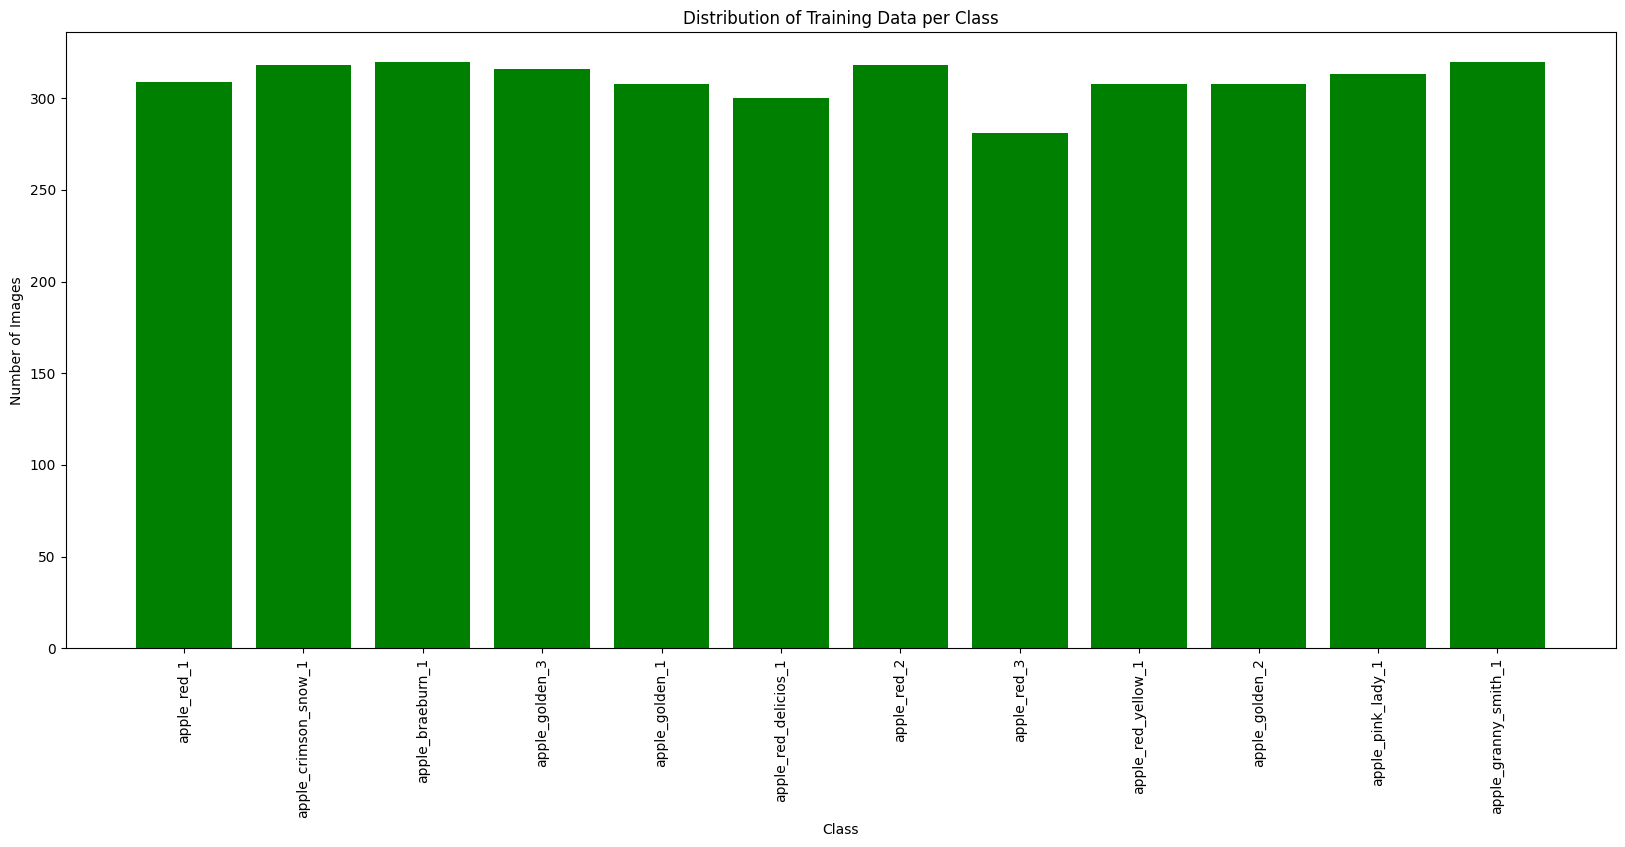

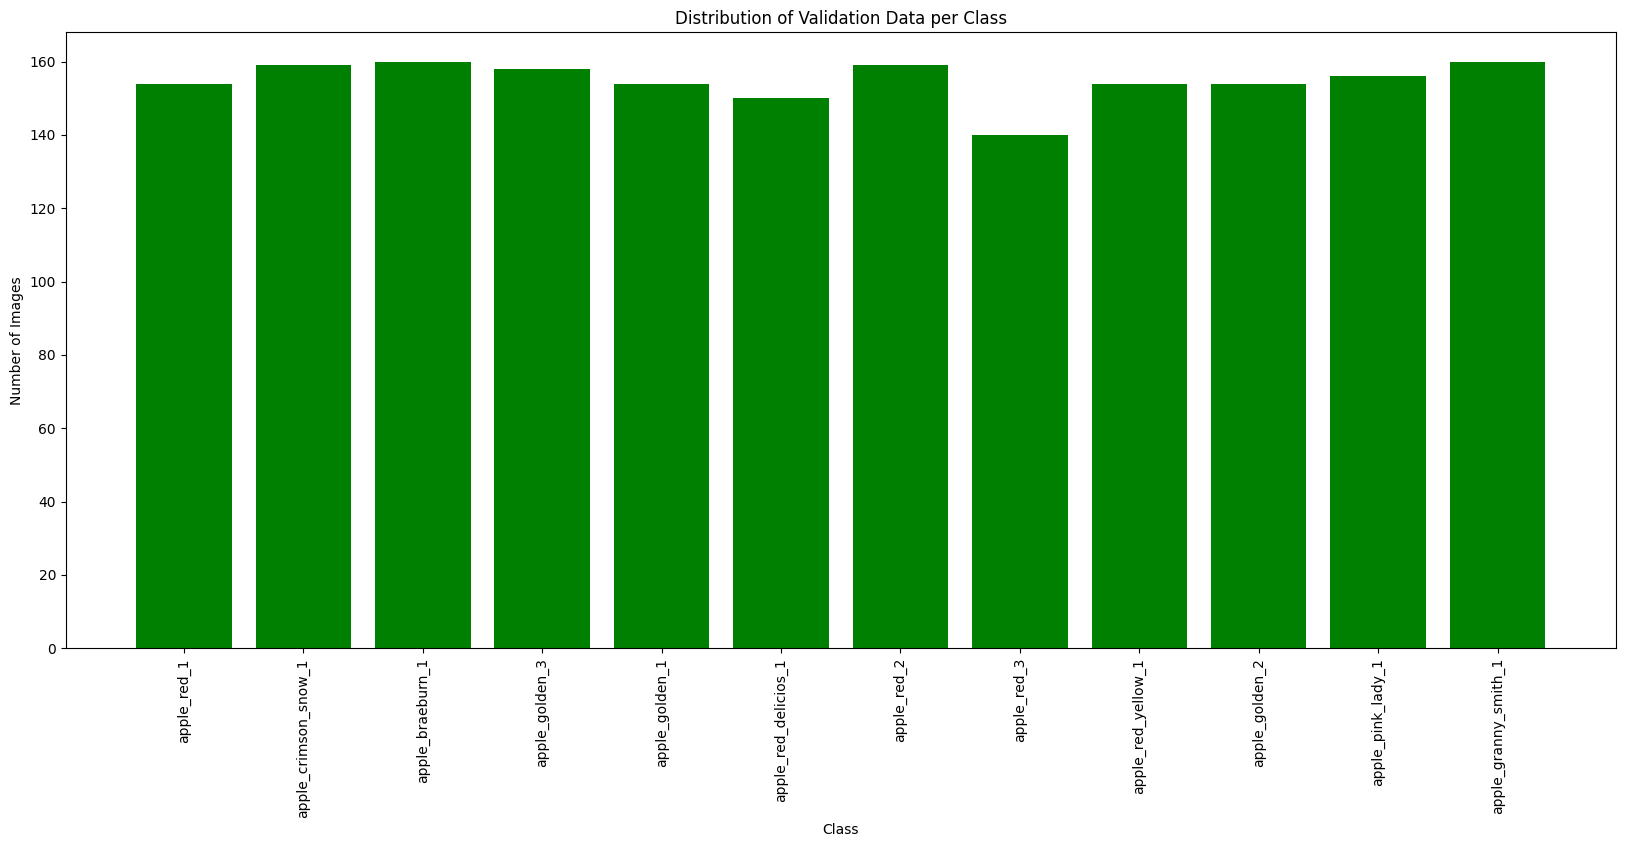

In [ ]:
if presplit:
    plot_images_per_class(images_path, mode='Training', title='Distribution of Training Data per Class')
    plot_images_per_class(images_path, mode='Test', title='Distribution of Validation Data per Class')

In [ ]:
net_model = resnet.resnet18(pretrained=True)
net_name = 'resnet18'

dropout_ratio = 0.25

net_model = load_network(net_model, net_name, dropout_ratio, class_names)

print(f'Images in training set {len(training_set)}, validation set {len(validation_set)}, testing set {len(testing_set)}')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 83.0MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

11,310,924 total parameters
134,412 training parameters
Images in training set 3719, validation set 1858, testing set 1858


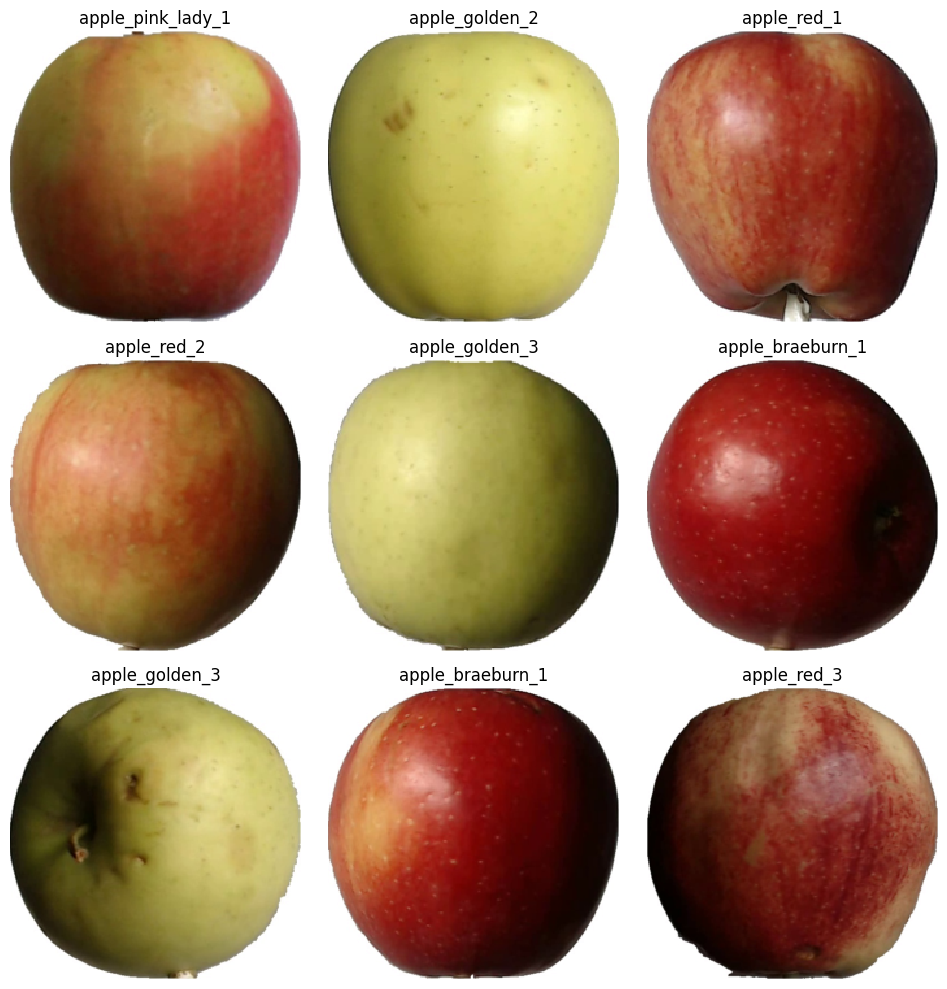

In [ ]:
plot_grid_images(training_set, batch_size, class_names, mean, std, rows=3, columns=3, size=10)

In [ ]:
learning_rate = 0.001
epochs = 25
momentum = 0.9
weight_decay = 0
patience = 3
n_epochs_stop = 5

net_model, loss_acc, y_testing, preds = train_model(results_path, net_name, net_model, training_set_loader, validation_set_loader,
                                                    learning_rate, epochs, momentum, weight_decay, patience, n_epochs_stop)

Using 1 GPUs
[train] Epoch 1/25 Iteration 1/15 Loss: 0.21 Accuracy: 0.98
[train] Epoch 1/25 Iteration 4/15 Loss: 0.23 Accuracy: 0.97
[train] Epoch 1/25 Iteration 7/15 Loss: 0.22 Accuracy: 0.97
[train] Epoch 1/25 Iteration 10/15 Loss: 0.20 Accuracy: 0.97
[train] Epoch 1/25 Iteration 13/15 Loss: 0.18 Accuracy: 0.98
[train] Epoch 1/25 Iteration 15/15 Loss: 0.17 Accuracy: 0.98
[val] Epoch 1/25 Iteration 1/8 Loss: 0.08 Accuracy: 1.00
[val] Epoch 1/25 Iteration 2/8 Loss: 0.08 Accuracy: 0.99
[val] Epoch 1/25 Iteration 3/8 Loss: 0.08 Accuracy: 0.99
[val] Epoch 1/25 Iteration 4/8 Loss: 0.08 Accuracy: 1.00
[val] Epoch 1/25 Iteration 5/8 Loss: 0.08 Accuracy: 1.00
[val] Epoch 1/25 Iteration 6/8 Loss: 0.08 Accuracy: 1.00
[val] Epoch 1/25 Iteration 7/8 Loss: 0.08 Accuracy: 1.00
[val] Epoch 1/25 Iteration 8/8 Loss: 0.08 Accuracy: 1.00
[val] Epoch 1/25 Iteration 8/8 Loss: 0.08 Accuracy: 1.00
[train] Epoch 2/25 Iteration 1/15 Loss: 0.10 Accuracy: 1.00
[train] Epoch 2/25 Iteration 4/15 Loss: 0.10 Accura

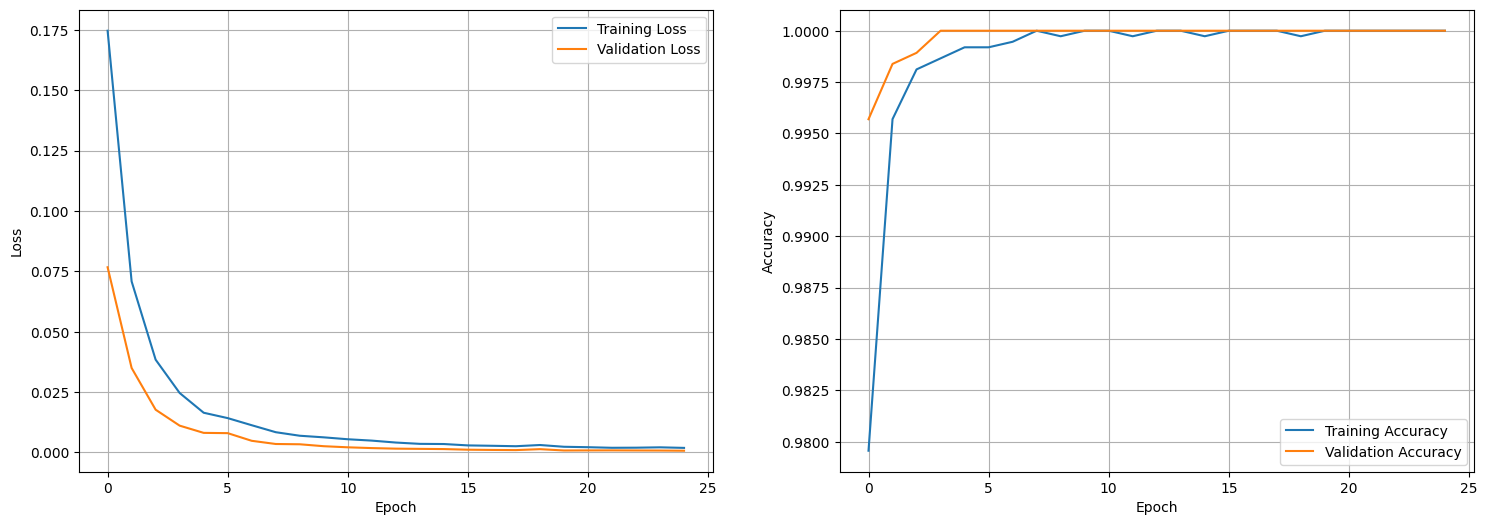

In [ ]:
plot_logs_classification(results_path, net_name, loss_acc)

In [ ]:
preds_test, y_true = test_model(net_name, net_model, testing_set_loader)

Iteration 1/8
Iteration 2/8
Iteration 3/8
Iteration 4/8
Iteration 5/8
Iteration 6/8
Iteration 7/8
Iteration 8/8


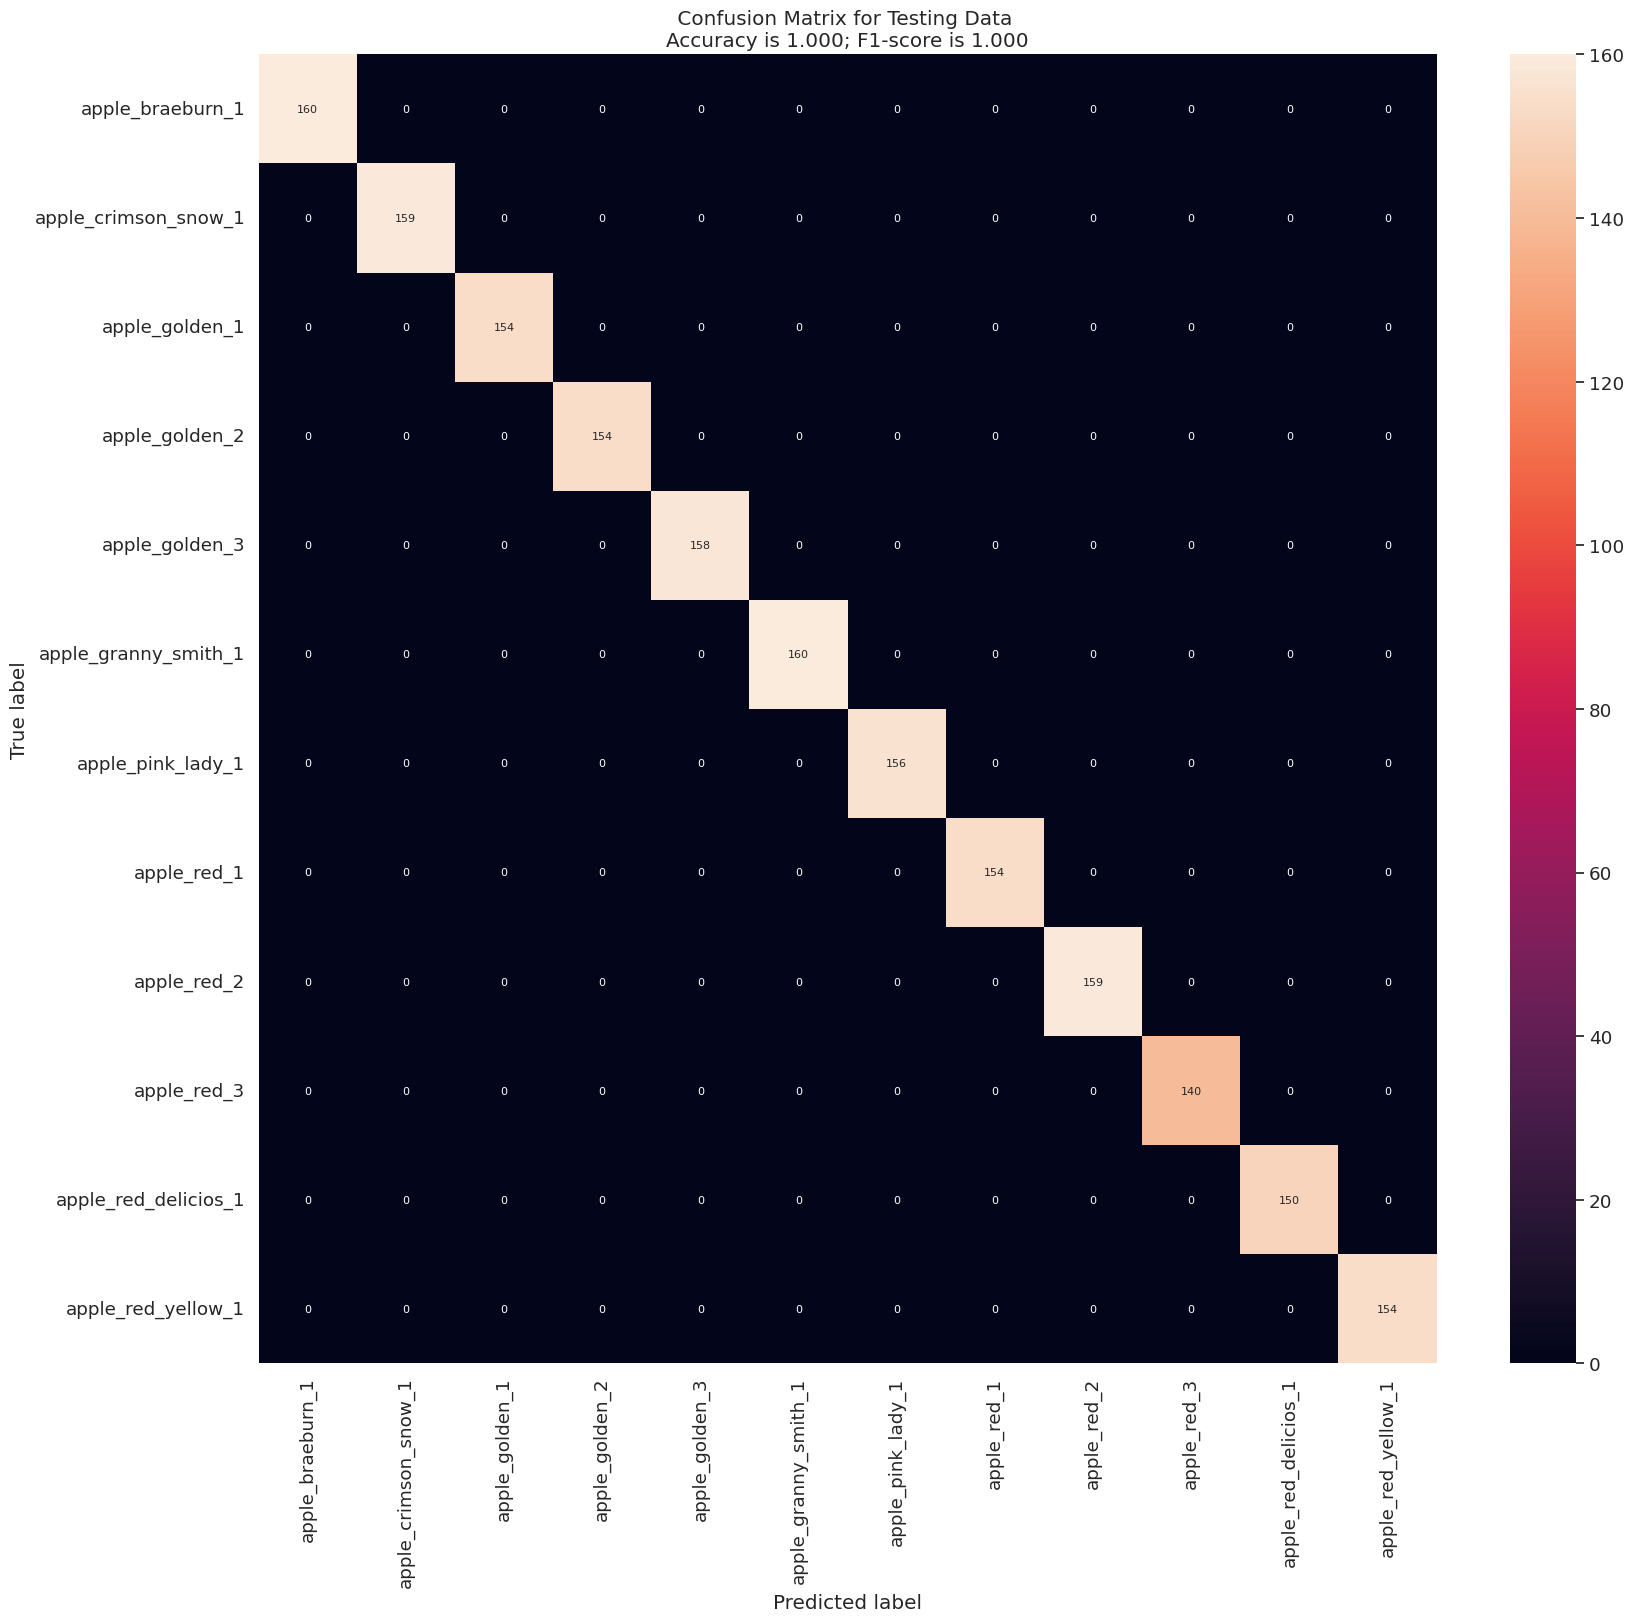

In [ ]:
display_confusion_matrix(results_path, net_name, y_true, preds_test, class_names, annot=True, figsize=(19,17), fontsize=8)

In [ ]:
print(classification_report(y_true, preds_test.argmax(1), target_names=class_names))

                      precision    recall  f1-score   support

    apple_braeburn_1       1.00      1.00      1.00       160
apple_crimson_snow_1       1.00      1.00      1.00       159
      apple_golden_1       1.00      1.00      1.00       154
      apple_golden_2       1.00      1.00      1.00       154
      apple_golden_3       1.00      1.00      1.00       158
apple_granny_smith_1       1.00      1.00      1.00       160
   apple_pink_lady_1       1.00      1.00      1.00       156
         apple_red_1       1.00      1.00      1.00       154
         apple_red_2       1.00      1.00      1.00       159
         apple_red_3       1.00      1.00      1.00       140
apple_red_delicios_1       1.00      1.00      1.00       150
  apple_red_yellow_1       1.00      1.00      1.00       154

            accuracy                           1.00      1858
           macro avg       1.00      1.00      1.00      1858
        weighted avg       1.00      1.00      1.00      1858



In [ ]:
torch.save(net_model, "Aubai_resnet_18_new_traning_8_15_2023.pth")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torch.autograd import Variable
from torchvision import transforms
import PIL
import cv2

In [ ]:
data_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [ ]:
model_3 = torch.load('/content/Aubai_resnet_18_new_traning_8_15_2023.pth')

In [ ]:
import torchvision.transforms as transforms
from PIL import Image

import io

def transform_image(image_bytes):
    my_transforms = transforms.Compose([transforms.RandomResizedCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize(
                                            [0.5, 0.5, 0.5],
                                            [0.5, 0.5, 0.5])])
    image = Image.open(io.BytesIO(image_bytes))
    return my_transforms(image).unsqueeze(0)


In [ ]:
with open("/content/Early_Golden.jpg", 'rb') as f:
    image_bytes = f.read()
    tensor = transform_image(image_bytes=image_bytes)
    print(tensor)


tensor([[[[-0.6000, -0.6157, -0.6549,  ..., -0.6784, -0.6314, -0.5843],
          [-0.5765, -0.6157, -0.6627,  ..., -0.6706, -0.6078, -0.5608],
          [-0.5843, -0.6235, -0.6549,  ..., -0.6706, -0.5922, -0.5451],
          ...,
          [ 0.8588,  0.8667,  0.8667,  ...,  0.0039,  0.0118,  0.0118],
          [ 0.8588,  0.8588,  0.8588,  ...,  0.0039,  0.0196,  0.0196],
          [ 0.8588,  0.8588,  0.8588,  ..., -0.0039, -0.0118, -0.0118]],

         [[-0.3882, -0.4118, -0.4510,  ..., -0.4824, -0.4196, -0.3882],
          [-0.3647, -0.4118, -0.4510,  ..., -0.4745, -0.4118, -0.3569],
          [-0.3725, -0.4196, -0.4588,  ..., -0.4745, -0.3882, -0.3412],
          ...,
          [ 0.6941,  0.6941,  0.6941,  ..., -0.2235, -0.2235, -0.2157],
          [ 0.6941,  0.6941,  0.6941,  ..., -0.2314, -0.2157, -0.2000],
          [ 0.6941,  0.6784,  0.6784,  ..., -0.2392, -0.2392, -0.2314]],

         [[-0.6549, -0.7020, -0.7412,  ..., -0.7882, -0.7647, -0.7255],
          [-0.6471, -0.7020, -

In [ ]:
device = torch.device('cpu')
device

device(type='cpu')

In [ ]:
device_avail = torch.cuda.is_available()

if not device_avail:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
net = model_3.to(device)

In [ ]:
net.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
def get_prediction(image_bytes):
    tensor = transform_image(image_bytes=image_bytes)
    tensor = tensor.to(device) #Moving tensor to the available device
    outputs = net.forward(tensor)
    _, y_hat = outputs.max(1)
    return y_hat

In [ ]:
with open("/content/Pink_lady.jfif", 'rb') as f:
    image_bytes = f.read()
    print(get_prediction(image_bytes=image_bytes))

tensor([6])


In [ ]:
with open("/content/Early_Golden.jpg", 'rb') as f:
    image_bytes = f.read()
    print(get_prediction(image_bytes=image_bytes))

tensor([3])


In [ ]:
with open("/content/real_test_apple.jpg", 'rb') as f:
    image_bytes = f.read()
    print(get_prediction(image_bytes=image_bytes))

tensor([6])
